<h1>RF Tools Demo </h1>
    
Demo for the rf_tools octave package

ISMRM 2019, Montreal Canada

Run this with

    jupyter notebook rf_tools_demo.ipynb
    
This requires that octave be installed, the signal toolbox, and the octave kernel for jupyter.

<h2> Outline </h2>

There are four parts to this tutorial
- RF Pulse simulator -- abr.m
- Shinnar-Le Roux pulse design routines -- b2rf.m, and friends
- Minimum and maximum phase pulses -- dzmp.m
- 2D spiral pulse design -- dz2d.m

The first three sections cover the Shinnar-Le Roux (SLR) pulse design method described in

"Parameter relations for the Shinnar-Le Roux selective excitation pulse design algorithm," J Pauly, P Le Roux, D Nishimura, A Macovski IEEE transactions on medical imaging 10 (1), 53-65

First we need to load the signal toolbox

In [1]:
pkg load signal

<h2> RF Pulse Simulator </h2>

rf_tools has an RF pulse simulator that computes the rotations produced by
your rf pulses.

It does this using spinors, and the Cayley-Klein parameters $\alpha$ and $\beta$.
These two complex numbers completely define a rotation.

Once the rotation has been computed, any RF profile can be computed.

First, we need an RF pulse

In [2]:
rf = msinc(256,2);

This is just a Hamming windowed sinc.

Normalize to $\pi/2$, and plot it.  cplot() takes a complex signal and plots both the real and imaginary parts.

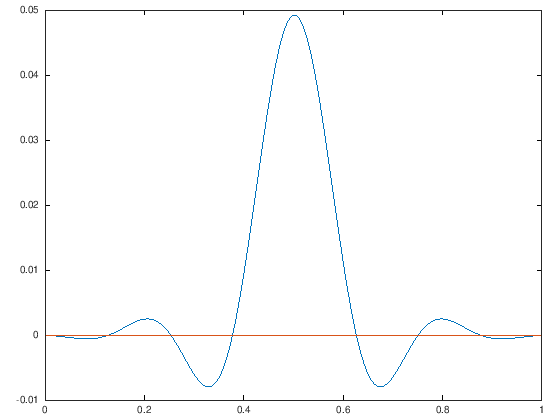

In [3]:
rf = rf*(pi/2)/sum(rf);
cplot(rf);

Next we need a vector of spatial locations.  By default the 
simulator assumes that the gradient area integrates to 2 pi over 
the pulse, so the spatial locations are multiples of 2 pi.

In [4]:
x = [-64:64]/4;

Then we simulate the result with abr(rf,x).  This stands for "alpha-beta rotator",

In [5]:
[a b] = abr(rf,x);

The $\alpha$ slice profile mostly characterizes the phase of the profile.

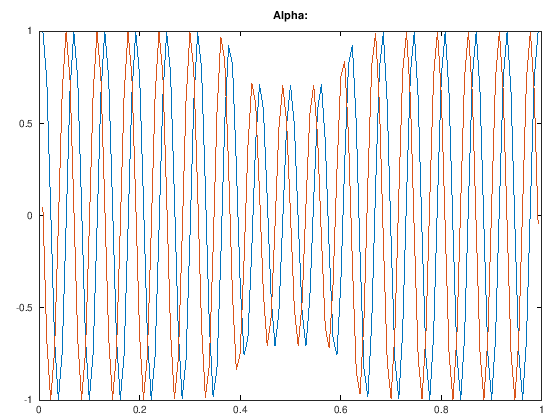

In [6]:
cplot(a)
title("Alpha:");

The $\beta$ profile looks like the slice profile we expect, and has an amplitude of $\sin(\phi/2)$ if $\phi$ is the flip angle.  This is a $\pi/2$ pulse so the amplitude is $\sin(\pi/4) = \sqrt{2}/{2}$, or about 0.707.  It is negative because we are using right hand rotations, while protons rotate in the negative sense,

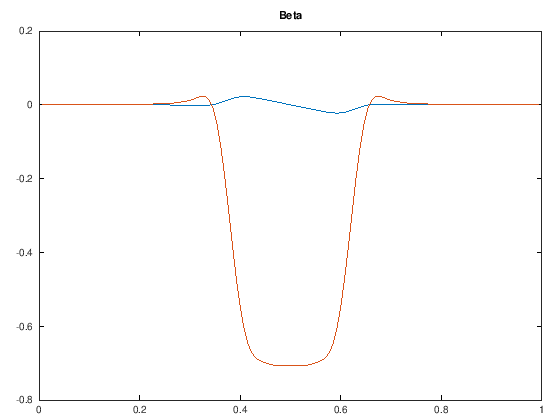

In [7]:
cplot(b)
title("Beta");

This is the $\beta$ slice profile. $\alpha$ and $\beta$ determine the rotation produced by the RF pulse for any initial magnetization.  We can then compute any slice profile we'd like.

The excitation profile is $M_{xy} = 2 \alpha^*\beta$, and this is computed by ab2ex(a,b),

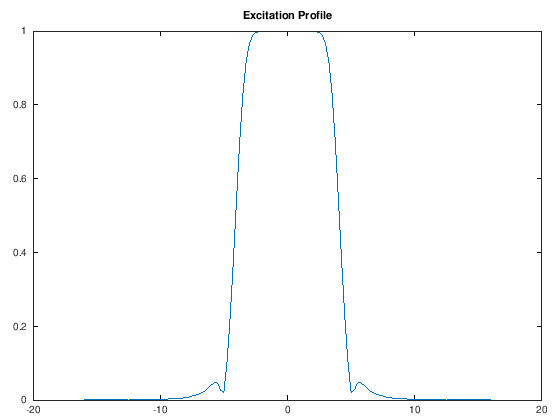

In [8]:
mxy_ex = ab2ex(a,b);
plot(x,abs(mxy_ex));
title("Excitation Profile");

The inversion profile is $M_z = 1-2\beta\beta^*$, and is computed by ab2inv(a,b),

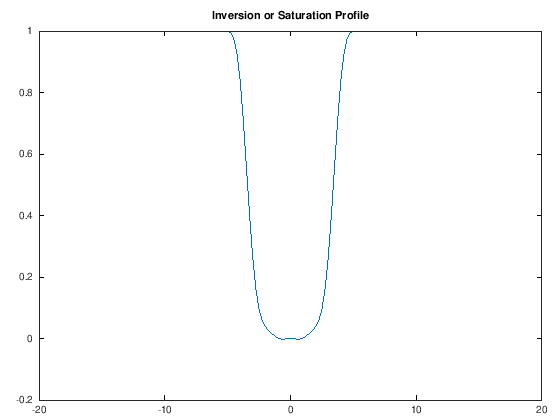

In [9]:
mz_inv = ab2inv(a,b);
plot(x, real(mz_inv));
title("Inversion or Saturation Profile");

The spin echo profile is $M_{xy} =  -i \beta^2$, and is computed by ab2se(a,b),

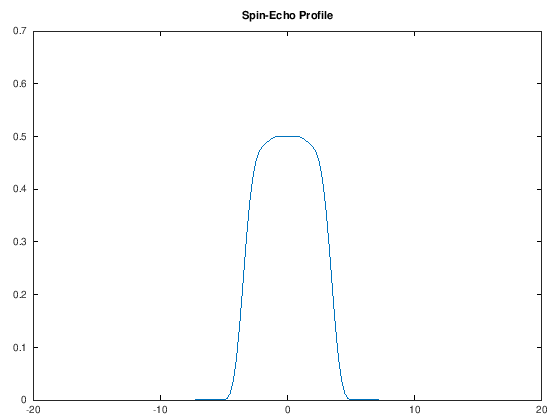

In [10]:
mxy_se = ab2se(a,b);
plot(x, real(mxy_se));
title("Spin-Echo Profile");

Not too surprising, a $\pi/2$ pulse is not a great spin echo pulse.

Now we just need better RF pulses to simulate! That is next.

<h2> Shinnar-Le Roux Pulse design demo </h2>

The previous section showed how to simulate the profile of an RF pulse.
In this section we show how to design much better RF pulses.

The SLR design starts by designing the beta polynomial, which is a lowpass
function scalled to sine of half the flip angle.  For an inversion pulse, 
this is sin(pi/2) = 1;

We start with a windowed sinc again

In [11]:
b = msinc(256,2);

This is scaled to 1, which is what we want.  We then design a consistent
$\alpha$, and then solve for the RF pulse. $\alpha$is determined uniquely 
given that we want a minimum power pulse, so the result is

In [12]:
rf = b2rf(b);

We will compare this to the windowed sinc scaled to $\pi$,

In [13]:
rfw = b*pi;

Compute the two responses as inversions.

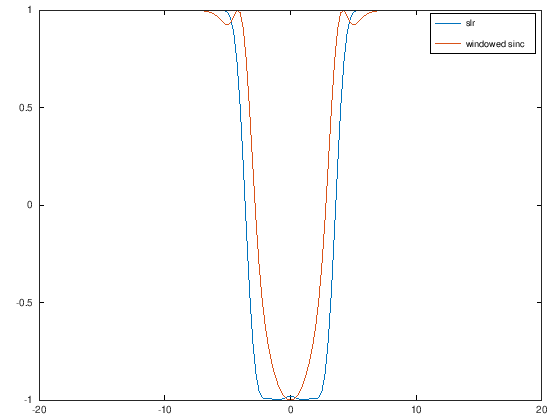

In [14]:
x = [-64:64]/4;
mz = ab2inv(abr(rf,x));
mzw = ab2inv(abr(rfw,x));
plot(x,mz,x,mzw);
legend("slr","windowed sinc");

Note the sharper profile of the SLR pulse.  This comes at a cost if we
compare RF pulses

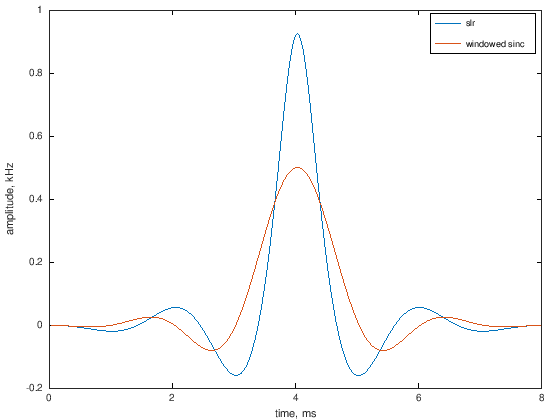

In [15]:
t = [1:256]/32;
plot(t,rfscale(rf,8),t,rfscale(rfw,8));
legend("slr","windowed sinc");
xlabel('time, ms')
ylabel('amplitude, kHz')

rfscale(rf,t) takes an RF pulse that sums to its flip angle, and a pulse 
duration in ms, and scales it to an RF amplitude in kHz.  

The SLR pulse has almost twice the peak amplitude. Note that the SLR pulse has closer zero spacing, even though it was based on the windowed sinc waveform.

There are lots of different types of RF pulses (excitaiton, inversion, spin-echo, etc) and lots of different types of filter designs to base them on.  rf_tools provides a wrapper for thses called dzrf(n,tb,'pulse_type','filter_type',d1, d2).  If you 

In [16]:
help dzrf

'dzrf' is a function from the file /Users/johnpauly/Dropbox/rf_tools_octave/dzrf.m

   rf = dzrf(np,tb,ptype,ftype,d1,d2)

  Designs an rf pulse.  There are a lot of options, most of
  which have defaults.  For example, a reasonable 100 sample
  tb=4 spin-echo pulse can be designed with

   rf = dzrf(100,4,'se')

  Inputs are:
    np -- number of points.         (required)
    tb -- time-bandwidth product    (required)
    ptype -- pulse type.  Options are:
      st  -- small tip angle         (default)
      ex  -- pi/2 excitation pulse
      se  -- pi spin-echo pulse
      sat -- pi/2 saturation pulse
      inv -- inversion pulse
    ftype -- filter design method.  Options are:
      ms  -- Hamming windowed sinc (an msinc)
      pm  -- Parks-McClellan equal ripple
      ls  -- Least Squares           (default)
      min -- Minimum phase (factored pm)
      max -- Maximum phase (reversed min)
    d1 -- Passband ripple        (default = 0.01)
    d2 -- Stopband ripple        (default =

For example, to design a very low ripple inversion pulse using an equal ripple Parks-McClellan design, 

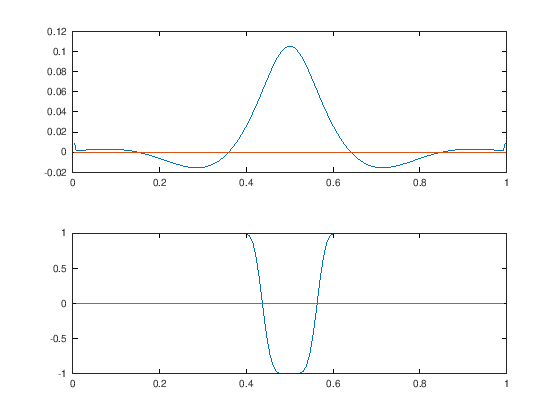

In [17]:
rf = dzrf(256,4,'inv','pm',0.001,0.001);

subplot(211);
cplot(rf);

subplot(212)
cplot(ab2inv(abr(rf,x)));

Something to try:
- Look at how the RF pulses and profiles chance as the flip angle decreases
- Scale $\beta$ to $\sin(\pi*0.99/2)$, $\sin(\pi*0.95/2)$, and $\sin(\pi*0.9/2)$ using the msinc filter from above.

<h2> Minimum and Maximum Phase RF Pulses </h2>

The SLR designs so far have been linear phase:
- They refocus (almost) perfectly
- They can be used as spin echo pulses


If you don't care about phase, there are much more selective pulses:
- Saturation pulses
- Inversion pulses
- Slab select pulses

These can be almost twice as selective as linear phase pulses.

You can design a minimum phase pulse by first designing a mimimum
phase $\beta$, scaling it to $\sin(\phi/2)$, where $\phi$ is your flip angle.

The function dzmp(n,tb,d1,d2) designs a minimum phase waveform with n samples, a time-bandwdith product of 8, and a passband ripple of d1, and a stopband ripple of d2. These are equalripple designs, which can end up with spikes ("Conolly wings") at the ends. The output of dzmp is  scaled to 1, so this corresponds to an inversion pulse.

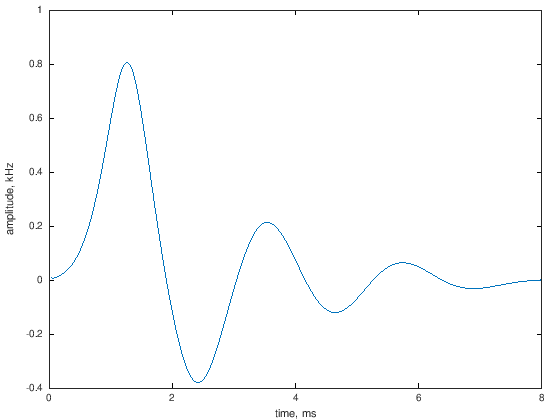

In [18]:
bm = dzmp(256,8,0.001,0.001);
rfm = b2rf(bm);
t = [1:256]/32;
plot(t,real(rfscale(rfm,8)));
xlabel('time, ms');
ylabel('amplitude, kHz');

The linear phase inversion with the same time bandwidth product from the pevious demos is

In [19]:
bl = msinc(256,2);
rfl = b2rf(bl);

Comparing the two rf pulses

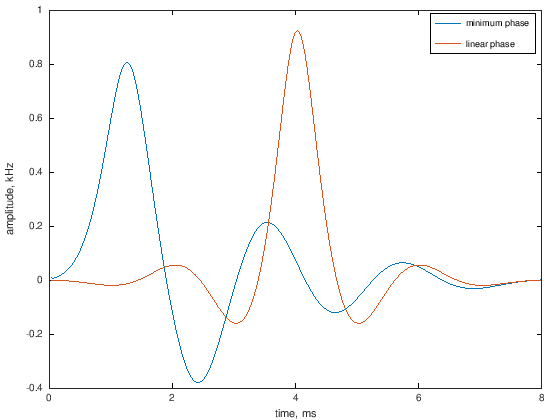

In [20]:
plot(t,real(rfscale(rfm,8)),t,real(rfscale(rfl,8)));
legend('minimum phase', 'linear phase');
xlabel('time, ms');
ylabel('amplitude, kHz');

We can compare the profiles as

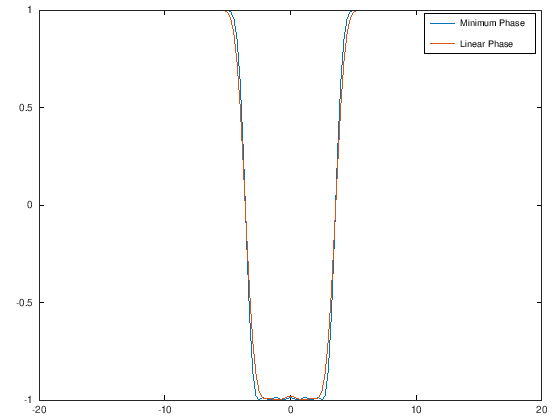

In [21]:
x = [-64:64]/4;
mzm = ab2inv(abr(rfm,x));
mzl = ab2inv(abr(rfl,x));
plot(x,mzm,x,mzl);
legend("Minimum Phase ","Linear Phase");

Zooming in on the transition bands

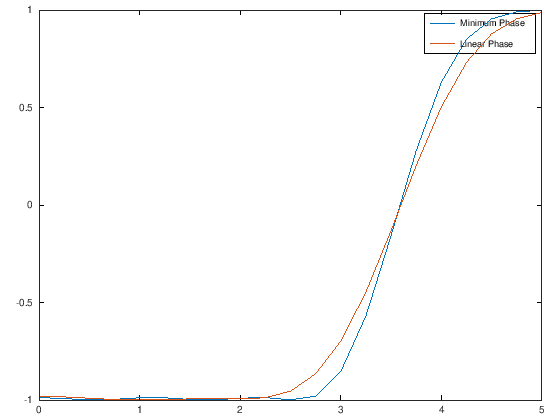

In [22]:
plot(x,mzm,x,mzl);
legend("Minimum Phase ","Linear Phase");
axis([0 5 -1 1]);

This can be useful for other pulses, such as slab select pulses

Something to try:
- Design a minimum phase excitation pulse (scale $\beta$ to $\sqrt{2}/2$)
- Compare the complex excitation profile of the min phase pulse, and a max phase pulse (min phase reversed in time).

<h2> 2D Spiral Excitation Pulses </h2>

2D spiral pulses can be designed for any flip angle using Fourier designs
The flip angle is the Fourier transform of the k-space weighting.  This was described in

"A k-space analysis of small-tip-angle excitation" J Pauly, D Nishimura, A Macovski
Journal of Magnetic Resonance (1969) 81 (1), 43-56

"A linear class of large-tip-angle selective excitation pulses", J Pauly, D Nishimura, A Macovski
Journal of Magnetic Resonance (1969) 82 (3), 571-587

An example design is an eight turn pulse with 1 G/cm gradient, and 
2 G/cm/ms slew rates (10 mT/m and 20 mT/m/s)

In [23]:
[rf g] = dz2d(8,1,4,512,1,2);

Gradient duration is  8.205 ms


where the second argument is the spatial bandwidth in cycles/cm and
the fourth argument is the space-bandwidth product (like TBW for 1D pulses).

The pulse ends up being 8.2 ms. We can plot the RF pulse and $G_x$ and $G_y$ gradients as

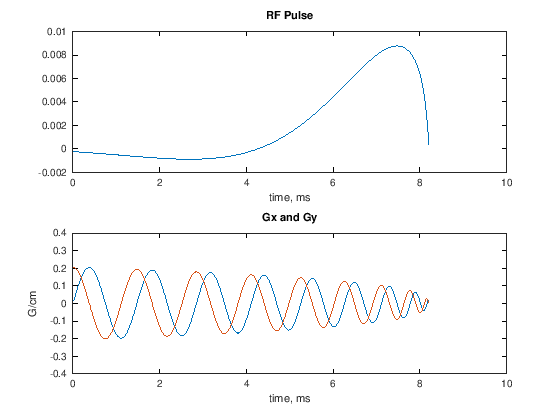

In [24]:
t = [1:512]*8.205/512;

subplot(211);
plot(t, rf);
xlabel('time, ms');
title('RF Pulse');
subplot(212)
plot(t, real(g),t,imag(g))
xlabel('time, ms');
ylabel('G/cm');
title('Gx and Gy');

Next we want to simulate the excitation profile.  At this point it is scaled
to 1 radian.  To increase it to $\pi/2$

In [25]:
rf = rf*pi/2;

The abr() simulator will take 2D pulses.  First define spatial vectors

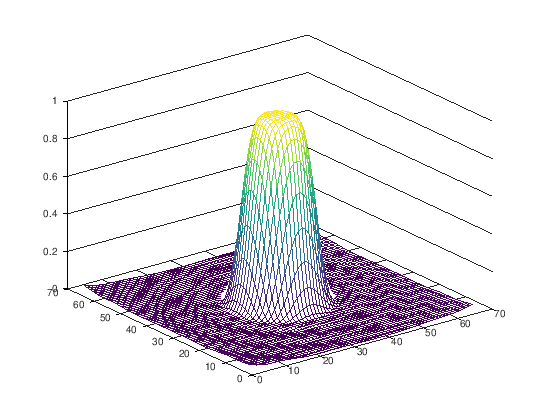

In [26]:
x = [-32:32]/4;
y = [-32:32]/4;

mxy = ab2ex(abr(rf,g,x,y));

mesh(abs(mxy));

This RF pulse is well refocused at the end of the pulse, as we can see by plotting $M_x$ and $-M_y$,

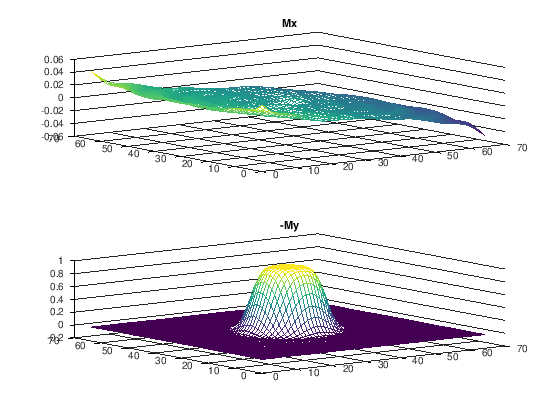

In [27]:
subplot(211);
mesh(real(mxy));
title('Mx');
subplot(212);
mesh(-imag(mxy));
title('-My');

$M_x$ is only a couple of percent.

We can simulate over a broader spatial range to visualize the sidelobes which are inherent in this type of design

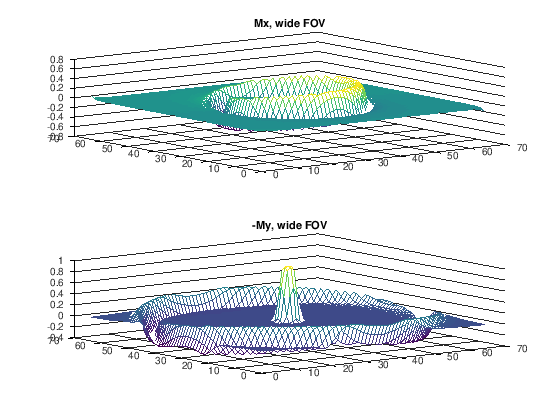

In [28]:
subplot(211)
mxy4 = ab2ex(abr(rf,g,x*4,y*4));
subplot(211)
mesh(real(mxy4))
title('Mx, wide FOV');

subplot(212)
mesh(-imag(mxy4))
title('-My, wide FOV');


Note that the main lobe is imaginary, the first sidelobe is real, 
and the second sidelobe is imaginary.  Extra credit if you can explain 
this!

We can use the same pulse as a spin-echo pulse if we increase the flip 
angle to $\pi$, and make sure the gradients integrate to zero.  Here we do this with a single sample, in fact you'd want to add an additional gradient lobe, or incorportate the area by adjusting one of the crusher gradients.

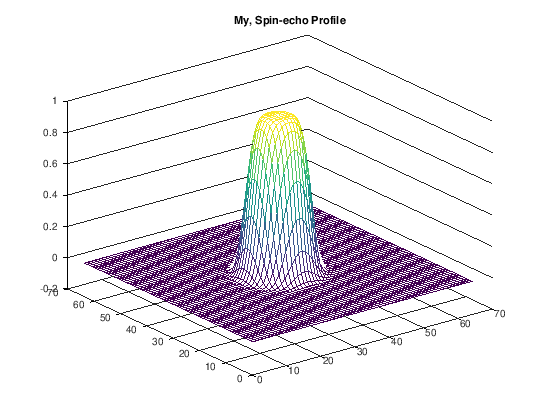

In [29]:
rfse = rf*2;

rfse = [0; rf*2];
gse = [-sum(g); g];

mxyse = ab2se(abr(rfse,gse,x,y));

mesh(real(mxyse));
title('My, Spin-echo Profile');

We've just plotted $M_y$ here, $M_x$ is again very small.

Things to try:
- Change the space-bandwidth product to 6 or 8
- Change the number of turns
- Do a two shot experiment, where g = -g for the second shot.  Add Mxy's.
- Use modern gradient numbers
